# 20 News Groups Benchmark
## SOWE Model (GloVe pre-trained Word Embeddings)

La seconda parte del benchmark viene effettuata con un modello denominato **sowe (Sum of Word Embeddings)** che consiste in una rete neurale composta da un layer di **EMBEDDING**, gli output del layer, corrispondenti ai word embeddings vengono sommati (creando un **Bag-Of-Embeddings**) attraverso un nodo custom denominato **nodo Lamda** che si occupa di sommare i word embeddings di ogni documento e passare il risultante vettore in input ad un **MLP** (incaricato della classificazione), composto da un layer hidden ed un layer di output con 20 unità corrispondenti ai 20newsgroups. 

Il modello è riassunto come segue:
<img src="./images/BoE+MLP.png" width="700" />

In [1]:
import warnings
import time
import tensorflow as tf
import tqdm

In [2]:
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
from utils import *
from plots import *

Using TensorFlow backend.


In [4]:
from keras.layers import Dense, Embedding, Dropout, LSTM, Lambda, Flatten, Reshape, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import backend as K
from keras.utils import normalize
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
MAX_SEQUENCE_LENGTH = 200     # lunghezza massima di una singola sequenza
EMBEDDING_DIM       = 300      # dimensione layer di embedding
LSTM_UNITS          = 150
VALIDATION_SPLIT    = 0.2
EPOCHS              = 100
BATCHES             = 128
NUM_CLASSES         = 20

In [6]:
# Load useful data
x_train           = loadPkl('x_train')
y_train           = loadPkl('y_train')
x_test            = loadPkl('x_test')
y_test            = loadPkl('y_test')

labels            = loadPkl('labels')
test_indicies     = loadPkl('test_indicies')
namesInLabelOrder = loadPkl('namesInLabelOrder')
word_index        = loadPkl('word_index')

## SOWE
### (GloVe Pre-Trained Word Embeddings)

In [7]:
'''
Costruiamo una rete neurale con un layer di embedding in ingresso ad una Lambda.
In uscita alla lambda mettiamo un MLP incaricato della classificazione.
In questo caso i word embeddings non sono appresi durante il fitting della rete
ma utilizzano dei word embeddings pre calcolati presenti nella matrice 'embedding_matrix'
calcolata usando vettori di parole pre calcolati (GloVe: Global Vector by Stanford NLP Group)
'''

embedding_matrix = getEmbeddingMatrix(word_index)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, 
                               mode='auto',patience=2, verbose=2, 
                               restore_best_weights=False)

sowe_GlV_model = Sequential()
sowe_GlV_model.add(Embedding(input_dim=len(word_index)+1, 
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, 
                        trainable=True))

sowe_GlV_model.add(Lambda(lambda x: K.sum(x, axis=1)))

sowe_GlV_model.add(Dense(256, activation='relu'))

sowe_GlV_model.add(Dropout(0.2))

sowe_GlV_model.add(Dense(NUM_CLASSES, activation='softmax'))

sowe_GlV_model.name = 'Sowe - GlV'

sowe_GlV_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['acc'])

print("Preparazione del modello...")
 
sowe_GlV_model.summary()

Preparazione del modello...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          32159100  
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 32,241,296
Trainable params: 32,241,296
Non-trainable params: 0
_________________________________________________________________


In [8]:
start_time = time.time()

sowe_GlV_history = sowe_GlV_model.fit(x=x_train,y=y_train,
                            epochs=EPOCHS,
                            batch_size=BATCHES,
                            shuffle=True,
                            validation_data=(x_test,y_test),
                            callbacks=[early_stop])

elapsed_time = time.time() - start_time

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

print ('Time Taken:')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

savePkl('sowe_GlV_history',sowe_GlV_history)
savePkl('sowe_GlV_model',sowe_GlV_model)

Train on 14636 samples, validate on 3660 samples
Epoch 1/100
14636/14636 [==============================] - 62s 4ms/step - loss: 3.1531 - acc: 0.4259 - val_loss: 1.5652 - val_acc: 0.5634
Epoch 2/100
14636/14636 [==============================] - 55s 4ms/step - loss: 1.3645 - acc: 0.6285 - val_loss: 1.2502 - val_acc: 0.6350
Epoch 3/100
14636/14636 [==============================] - 55s 4ms/step - loss: 0.9557 - acc: 0.7236 - val_loss: 1.1603 - val_acc: 0.6639
Epoch 4/100
14636/14636 [==============================] - 56s 4ms/step - loss: 0.6981 - acc: 0.7986 - val_loss: 1.1001 - val_acc: 0.6954
Epoch 5/100
14636/14636 [==============================] - 57s 4ms/step - loss: 0.5094 - acc: 0.8540 - val_loss: 1.0925 - val_acc: 0.6940
Epoch 6/100
14636/14636 [==============================] - 56s 4ms/step - loss: 0.4084 - acc: 0.8869 - val_loss: 1.0681 - val_acc: 0.7117
Epoch 7/100
14636/14636 [==============================] - 55s 4ms/step - loss: 0.3144 - acc: 0.9162 - val_loss: 1.0714 - v

### Preparing result & Plotting

In [9]:
result = {}

# loading model and history
#sowe_GlV_history       = loadPkl('sowe_GlV_history')
#sowe_GlV_model         = loadPkl('sowe_GlV_model')

# building result
result['history'] = sowe_GlV_history.history
result['test_loss'], result['test_accuracy'] = sowe_GlV_model.evaluate(x_test, y_test, verbose=2)

# testing model on validation data
prediction        = sowe_GlV_model.predict(x_test, verbose=2)
prediction_labels = prediction.argmax(axis=1)

# building result
result['confusion_matrix'] = confusion_matrix(labels[test_indicies],prediction_labels).tolist()
result['classification_report'] = classification_report(labels[test_indicies],prediction_labels,digits=4,
                                                        target_names=namesInLabelOrder, output_dict=True)

# building confusion matrix
cm = result['confusion_matrix']
cm = np.array([np.array(xi) for xi in cm])

print("Test Loss: ",result['test_loss'])
print("Test accuracy: ",result['test_accuracy'])

Test Loss:  1.0842152226166648
Test accuracy:  0.7215846994535519


Generating confusion matrices...


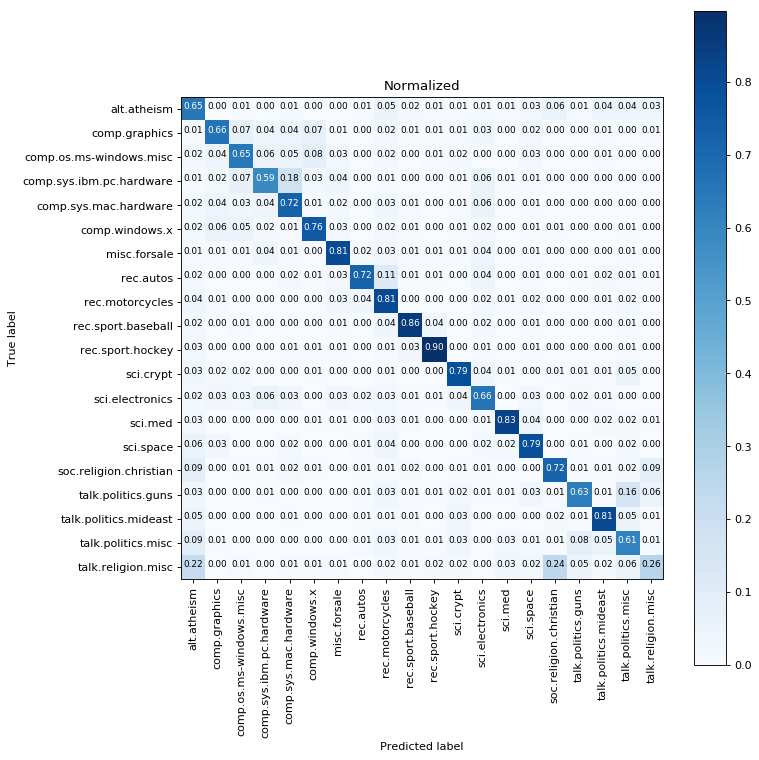

In [10]:
plot_confusion_matrix(cm, 'sowe_GlV_model', normalize=True, title='Normalized')

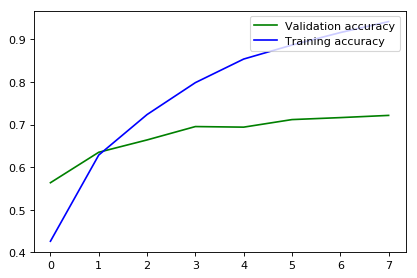

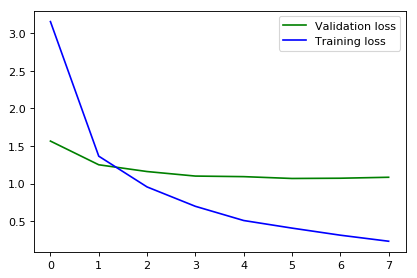

In [11]:
# plotting convergence
plotConvergence(result['history'],'sowe_GlV_model')

## End